In [28]:
import pandas as pd

from pathlib import Path
from sklearn.model_selection import train_test_split
# you will have to have the following in your path (see README.md and navigate to the related repos)
from loe import LoE
from hdtree import HDTreeClassifier, FixedValueSplit, TenQuantileSplit, TenQuantileRangeSplit, TwentyQuantileSplit, \
    SmallerThanSplit, TwentyQuantileRangeSplit, GiniMeasure
import logging
from rule_loe import RuleLoE
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

%matplotlib inline

In [29]:
logging.basicConfig(level=logging.INFO)

## Example UCI Cancer data set
2 class problem to distinguish malignant from benign tumors given some metrics of the tumor cells

In [30]:
df_cancer = pd.read_csv(Path('datasets', 'uci_cancer.csv'))

In [31]:
df_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


In [32]:
# typical train / test split
X_train, X_test, y_train, y_test = train_test_split(df_cancer.iloc[:, :-1], df_cancer.iloc[:, -1], test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test)


(455, 114)

In [33]:
# base models (for RuleGoN those have to be HDTrees)
trees_cancer = [HDTreeClassifier(allowed_splits=[  # SmallerThanSplit,

        # Splits (Rules) of HDTree can have restriction (e.g. at which levels they may occur)
        TenQuantileRangeSplit.build_with_restrictions(max_level=1),
        TenQuantileSplit.build_with_restrictions(max_level=0),
        TwentyQuantileRangeSplit.build_with_restrictions(min_level=1),
        TwentyQuantileSplit.build_with_restrictions(min_level=1),

        # Beware: this split is O(n^2 --> slow.)
        SmallerThanSplit.build_with_restrictions(min_level=1),
    ],

    # we need the model to know the attribute names
    attribute_names=df_cancer.columns[:-1],

    # some general parameters
    min_samples_at_leaf=5,

    # how the goodness-of-split is calculated
    information_measure=GiniMeasure(),

    # differrent amount of levels for each tree (for illustration)
    max_levels=i,
    verbose=False
    )
    
    # 4 models here
    for i in range(4)
]

In [34]:
loe = LoE(
    # the experts
    pool_classifiers=trees_cancer,

    # initial step size for movements
    step_size=2,

    # number of runs
    iterations=20,

    # you can evaluate performance partly on some not seen data to the model while  training (will be mixed into the train data for performance measure only)
    # val_perc=0.1,

    # will be used for moving the models (will be extracted as disjunct set from the training data) 
    DSEL_perc=0.3,

)

In [35]:
loe.fit(X_train, y_train)

INFO:LoE:Start performance: 0.916

INFO:LoE:Performing round 0
INFO:LoE:Current step size: 2.000
INFO:LoE:Performance: 0.941
INFO:LoE:Performance increase by 0.024
INFO:LoE:Round took 5.713 seconds

INFO:LoE:Performing round 1
INFO:LoE:Current step size: 1.900
INFO:LoE:Performance: 0.965
INFO:LoE:Performance increase by 0.024
INFO:LoE:Round took 15.833 seconds

INFO:LoE:Performing round 2
INFO:LoE:Current step size: 1.800
INFO:LoE:Performance: 0.963
INFO:LoE:Round took 12.947 seconds

INFO:LoE:Performing round 3
INFO:LoE:Current step size: 1.700
INFO:LoE:Performance: 0.974
INFO:LoE:Performance increase by 0.009
INFO:LoE:Round took 8.176 seconds

INFO:LoE:Performing round 4
INFO:LoE:Current step size: 1.600
INFO:LoE:Performance: 0.967
INFO:LoE:Round took 12.827 seconds

INFO:LoE:Performing round 5
INFO:LoE:Current step size: 1.500
INFO:LoE:Performance: 0.965
INFO:LoE:Round took 11.177 seconds

INFO:LoE:Performing round 6
INFO:LoE:Current step size: 1.400
INFO:LoE:Performance: 0.969
INFO

In [36]:
# Build 2 RuleGons from the LoE having two different max lengths for the assignment process surrogate
rule_loe_1 = RuleLoE.from_loe_instance(loe, max_length_assignment=1)
rule_loe_2 = RuleLoE.from_loe_instance(loe, max_length_assignment=2)

In [37]:
# Agreement is the level where P(y|X) is the same for both models
print("Agreement level 1", rule_loe_1.calculate_agreement_with_loe(loe=loe, X=X_test))
print("Agreement level 2", rule_loe_2.calculate_agreement_with_loe(loe=loe, X=X_test))

Agreement level 1 0.9912280701754386
Agreement level 2 0.9912280701754386


In [38]:
print("Report for RuleLoE 1")
print(classification_report(rule_loe_1.predict(X_test), y_test))
print("Accuracy", rule_loe_1.score(X_test, y_test))

Report for RuleLoE 1
              precision    recall  f1-score   support

      benign       0.97      0.93      0.95        74
   malignant       0.88      0.95      0.92        40

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114

Accuracy 0.9385964912280702


In [39]:
print("Report for RuleLoE 2")
print(classification_report(rule_loe_2.predict(X_test), y_test))
print("Accuracy", rule_loe_2.score(X_test, y_test))

Report for RuleLoE 2
              precision    recall  f1-score   support

      benign       0.97      0.96      0.97        72
   malignant       0.93      0.95      0.94        42

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

Accuracy 0.956140350877193


## Explanations

In [41]:
print(
    "Rules for RuleLoE 1 with Coverage (= number of samples covered by the rule, Nerd = the model in the pool where the rule derives from, Prediction = the target of the rule)")
rule_loe_1.explain()

Rules for RuleLoE 1 with Coverage (= number of samples covered by the rule, Nerd = the model in the pool where the rule derives from, Prediction = the target of the rule)


,Rule 1,Rule 2,Rule 3,Rule 4,Coverage in Percent,Precision in Percent,Expert,Prediction
0,mean perimeter < 97.84,worst concave points < 0.14,area error < 38.45,,58.02,98.11,#4,benign
1,mean perimeter < 97.84,worst concave points ≥ 0.14,worst smoothness < 0.14,,2.42,63.64,#4,benign
2,"worst radius is INSIDE range [17.35, ..., 20.22[",worst concavity < 0.23,,,1.98,55.56,#3,benign
3,mean perimeter < 97.84,worst concave points < 0.14,area error ≥ 38.45,fractal dimension error is OUTSIDE range [0.00...,1.54,100.00,#4,benign
4,worst radius ≥ 20.22,,,,20.00,100.00,#1,malignant
5,"worst radius is INSIDE range [17.35, ..., 20.22[",worst concavity ≥ 0.23,,,8.13,97.30,#3,malignant
6,mean perimeter < 97.84,worst concave points ≥ 0.14,worst smoothness ≥ 0.14,,6.59,96.67,#4,malignant
7,mean perimeter < 97.84,worst concave points < 0.14,area error ≥ 38.45,"fractal dimension error is INSIDE range [0.00,...",1.32,100.00,#4,malignant


In [42]:
print(
    "Rules for RuleLoE 2 with Coverage (= number of samples covered by the rule, Nerd = the model in the pool where the rule derives from, Prediction = the target of the rule)")
rule_loe_2.explain()

Rules for RuleLoE 2 with Coverage (= number of samples covered by the rule, Nerd = the model in the pool where the rule derives from, Prediction = the target of the rule)


,Rule 1,Rule 2,Rule 3,Rule 4,Rule 5,Coverage in Percent,Precision in Percent,Expert,Prediction
0,mean perimeter < 97.84,worst radius < 17.06,worst concave points < 0.14,area error < 38.45,,57.58,98.09,#4,benign
1,mean perimeter < 97.84,worst radius < 17.06,worst concave points ≥ 0.14,worst smoothness < 0.14,,1.76,87.50,#4,benign
2,mean perimeter < 97.84,worst radius < 17.06,worst concave points < 0.14,area error ≥ 38.45,fractal dimension error is OUTSIDE range [0.00...,1.54,100.00,#4,benign
3,"worst radius is INSIDE range [17.35, ..., 20.22[",worst area < 1158.25,worst concavity < 0.23,,,1.10,80.00,#3,benign
4,worst radius ≥ 20.22,worst area ≥ 1298.5,,,,18.90,100.00,#1,malignant
5,"worst radius is INSIDE range [17.35, ..., 20.22[",worst area < 1158.25,worst concavity ≥ 0.23,,,6.37,96.55,#3,malignant
6,"mean radius is INSIDE range [15.00, ..., 19.50[","worst radius is INSIDE range [18.55, ..., 20.88[",,,,5.93,96.30,#2,malignant
7,mean perimeter < 97.84,worst radius < 17.06,worst concave points ≥ 0.14,worst smoothness ≥ 0.14,,4.84,95.45,#4,malignant


In [43]:
# Some metrics
print("Number of conditions for RuleLoE 1:", rule_loe_1.count_conditions())
rule_loe_2.count_conditions()
print("Number of rules for RuleLoE 1:", rule_loe_1.count_rules())

Number of conditions for RuleLoE 1: 22
Number of rules for RuleLoE 1: 8


## Details

/Users/ric.hard/Dropbox/dev/python_libs/libs/hdtree/src/split_rule.py:2229: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  attr = sample[attr_idx]


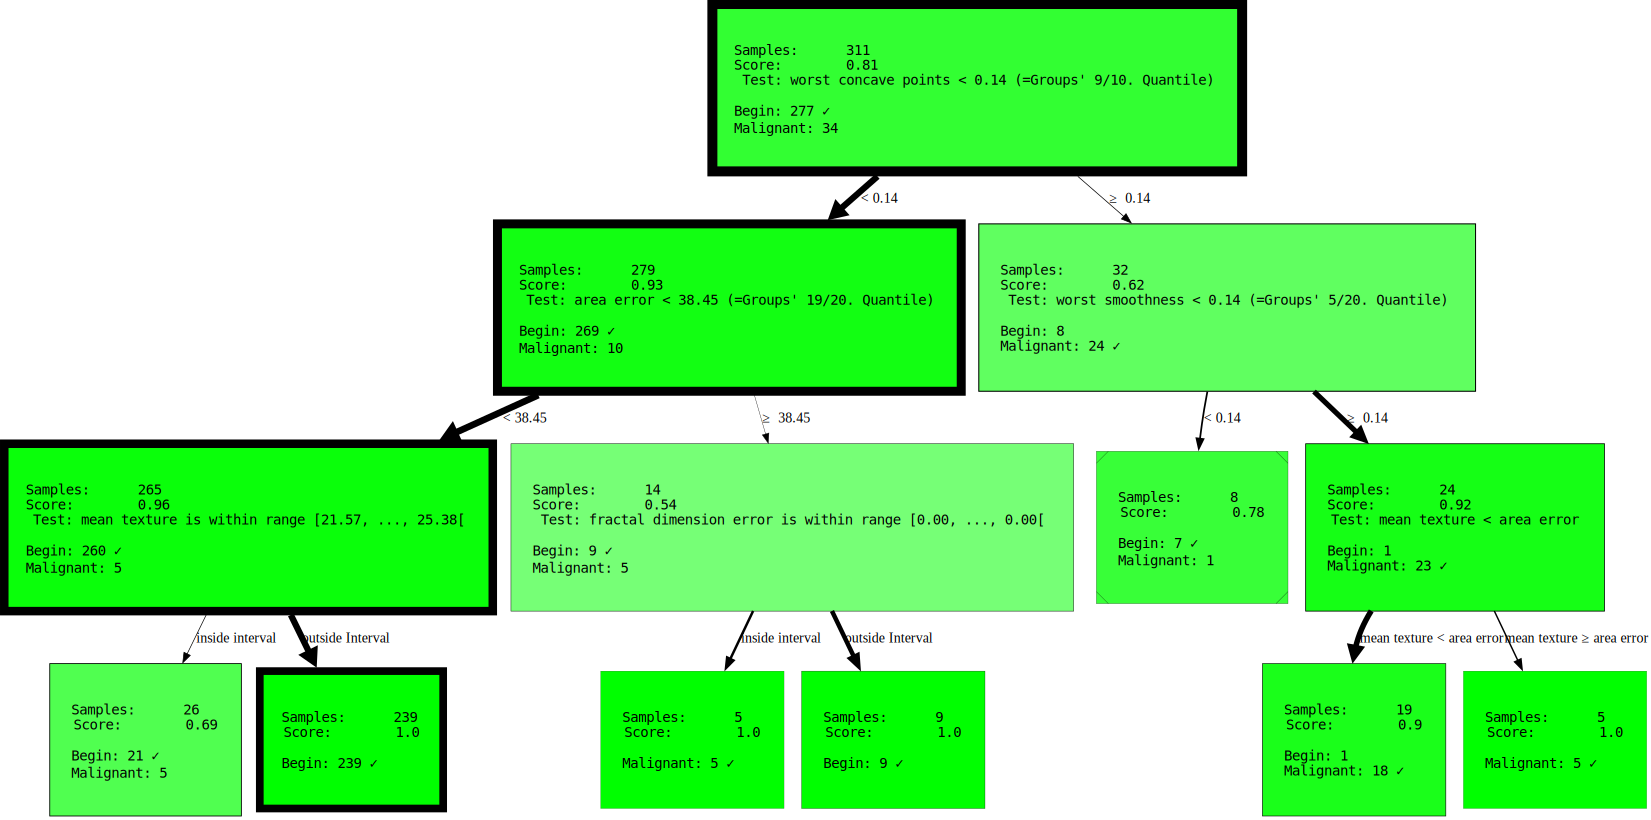

In [44]:
loe.pool_classifiers_[3].generate_dot_graph(label_lookup={0: "Begin", 1: "Malignant"},
                                            show_trace_of_sample=X_train.iloc[200])

/Users/ric.hard/Dropbox/dev/python_libs/libs/hdtree/src/split_rule.py:2229: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  attr = sample[attr_idx]


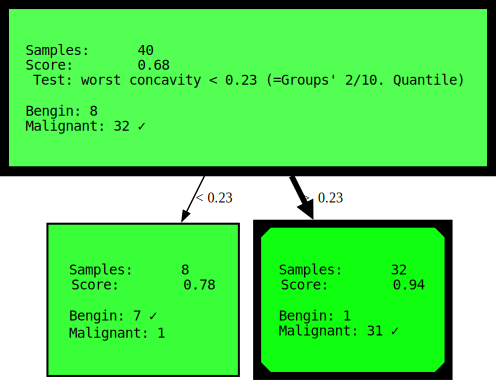

In [47]:
# will mark the leaves of the tree where the sample is going through
loe.pool_classifiers_[2].generate_dot_graph(show_trace_of_sample=X_train.iloc[0],
                                            label_lookup={0: "Bengin", 1: "Malignant"})

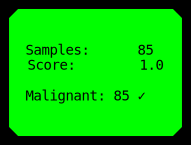

In [46]:
# be aware that this one has exactly 0 levels (as given by pool configuration). However it has still rules applied to it when generating the assignment function
loe.pool_classifiers_[0].generate_dot_graph(label_lookup={0: "Bengin", 1: "Malignant"},
                                            show_trace_of_sample=X_train.iloc[200])